### Questions
1. How to measure training or testing accuracy?
2. How many epochs to train the model?
3. How do I choose my hyperparameters?
4. What are the next steps?

## Carla custom dataset

In [1]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import pandas as pd

# Custom Dataloader for Carla
# Should access the CSV file of Carla and load all the data in it including the respective images 
# whose image path is defined in the csv file
class CarlaCustomDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Arguments:
            data: Variable to call the combined csv file with all the data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(data)
        self.transform = transform

        # Pre-filter data to include only valid images
        self.valid_data = []
        for _, row in self.data.iterrows():
            img_path = row['Image Path']
            label = row['Steer']
            if os.path.exists(img_path):
                try:
                    # Try loading the image to ensure it's not corrupted
                    with Image.open(img_path) as img:
                        img.convert("RGB")
                    self.valid_data.append((img_path, label))
                except Exception as e:
                    print(f"Skipping corrupted image {img_path}: {e}")    
    
    def __len__(self):
        return len(self.valid_data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Taking the image path from the csv file and loading the image
        img_path, steer = self.valid_data[idx] 

        image = Image.open(img_path).convert('RGB')  # Ensure image is loaded in RGB mode

        # Obtaining all the numerical data from the csv file
        #velocity = self.data.iloc[idx, 5]
        #throttle = self.data.iloc[idx, 6]
        #steer = self.data.iloc[idx, 7]
        #brake = self.data.iloc[idx, 8]
        #gear = self.data.iloc[idx, 12]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image,
                  #'velocity': velocity, 
                  #'throttle': throttle, 
                  #'brake': brake,
                  #'gear': gear,
                  'steer': steer}
        
        return sample

In [2]:
import pandas as pd
import glob
import os
import re

# Specify the path where the CSV files are located
csv_folder_path = r"C:\Users\Student\carla_notebook_files\csv_data_files"  # Replace with the actual path

# Get all the CSV files
csv_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))

# Function to extract the number at the beginning of the file name
def extract_number(file_name):
    match = re.match(r"(\d+)_", os.path.basename(file_name))
    return int(match.group(1)) if match else float('inf')

# Sort the CSV files by the number at the start of the file name
csv_files.sort(key=extract_number)

# Split the files into train, validation, and test sets
train_files = csv_files[:6]
test_files = csv_files[6:]

# Function to concatenate and save CSV files
def concatenate_and_save(file_list, output_path):
    dfs = [pd.read_csv(file) for file in file_list]
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_path, index=False)

# Save the train, validation, and test sets
concatenate_and_save(train_files, "train.csv")
concatenate_and_save(test_files, "test.csv")

print("CSV files successfully split and saved!")

CSV files successfully split and saved!


In [3]:
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split

# Example usage
#csv_file_1 = 'data_without_traffic.csv'
#csv_file_2 = 'data_with_traffic.csv'
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

# Reading both CSV files
#carla_dataframe_1 = pd.read_csv(csv_file_1)
#carla_dataframe_2 = pd.read_csv(csv_file_2)

# Concatenate the data
#carla_combined_dataframe = pd.concat([carla_dataframe_1, carla_dataframe_2], ignore_index=True)

# Split the data
#train_data, test_val_data = train_test_split(carla_combined_dataframe, test_size=0.3, shuffle=True, random_state=42)
#test_data, val_data = train_test_split(test_val_data, test_size=0.5, shuffle=True, random_state=42)

#train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

train_dataset = CarlaCustomDataset(data="train.csv", transform=transform)
test_dataset = CarlaCustomDataset(data="test.csv", transform=transform)
#val_dataset = CarlaCustomDataset(data=val_data, transform=transform)

In [4]:
# Accessing a sample
sample = train_dataset[123] # Here the row is counted excluding the first row
image, steer = sample['image'], sample['steer']
#brake, gear, , velocity = sample['brake'], sample['gear'], sample['velocity']
#print("Velocity:", velocity)
#print("Throttle:", throttle)
print("Steer:", steer)
#print("Brake:", brake)
#print("Gear:", gear)
print("Image shape:", image.shape)
print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Steer: 0.0136913005262613
Image shape: torch.Size([3, 224, 224])
Length of training dataset: 2000
Length of test dataset: 233


## Displaying an image to test the custom dataset

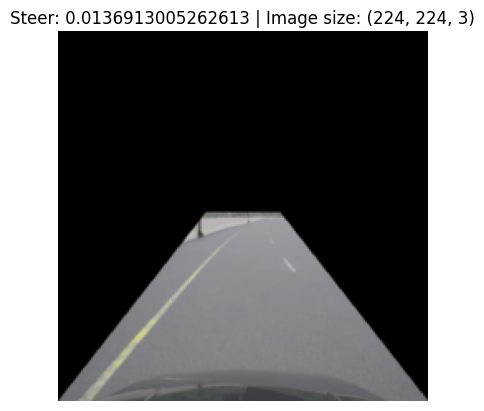

In [5]:
import matplotlib.pyplot as plt

# Convert the image into a numpy array
image_array = image.numpy()

# Transpose to get the shape [H, W, C]
# Always remember: PyTorch -> [C,H,W]  | Numpy & Matplotlib -> [H,W,C]
image_array = image_array.transpose(1, 2, 0)

plt.imshow(image_array)
plt.title(f"Steer: {steer} | Image size: {image_array.shape}")
plt.axis(False);

# Dataloader

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                              batch_size=64, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                             batch_size=1, 
                             num_workers=0, 
                             shuffle=False) # don't usually need to shuffle testing data

#val_dataloader = DataLoader(dataset=val_dataset,
#                            batch_size=1, 
#                            num_workers=0, 
#                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x28d2fa61f40>,
 <torch.utils.data.dataloader.DataLoader at 0x28d2fa61c10>)

In [7]:
# Iterate over the DataLoader and check the behavior
for batch in train_dataloader:
    print(f"Batch size: {len(batch['image'])}")
    # Optionally, print other parts of the batch to verify
    print(f"Steer values in batch: {batch['steer'].shape}")

Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size: 64
Steer values in batch: torch.Size([64])
Batch size

# Model

In [7]:
import torch
import torchvision
from torchvision.models import resnet18, ResNet18_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_dim = 1  # Only steering is considered

# model = torchvision.models.resnet18(pretrained=True)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(512, output_dim)

model = model.to(device)

In [8]:
# Freeze all layers by default
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the 'layer4' and fully connected (fc) layer
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [9]:
import torchinfo
from torchinfo import summary

summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

### Trial forward pass to test model functionality

In [10]:
# 1. Get a batch of images and labels from the DataLoader
img_batch = next(iter(train_dataloader))['image'].to(device)
#throttle_batch = next(iter(train_dataloader))['throttle'].to(device)
steer_batch = next(iter(train_dataloader))['steer'].to(device)

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, steer_single = img_batch[0].unsqueeze(dim=0), steer_batch[0]
print(f"Single image shape: {img_single.shape}")
#print(f"Single throttle value: {throttle_single}")
print(f"Single steer value: {steer_single}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
#print(f"Output throttle: {pred[0,0]}")
print(f"Output steer: {pred}")

Single image shape: torch.Size([1, 3, 224, 224])
Single steer value: -0.0038694941904395

Output steer: tensor([[0.7043]], device='cuda:0')


# Setting up loss, scheduler and optimiser function

In [11]:
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.MSELoss()
# Optimizer: Different LR for different layers
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5},  # Fine-tuning layer4
    {'params': model.fc.parameters(), 'lr': 1e-4}       # Fully connected layer
])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### Trial train testing

In [12]:
import numpy as np

y= []
error = 0

for batch in train_dataloader:
    X = batch['image'].to(device)
    #throttle = batch['throttle'].to(device)
    labels = batch['steer'].to(device).float()
    #labels = torch.stack((throttle, steer), dim=1).to(device)                      
    #print(f"Image shape: {X[0]}")
    #print(f"Throttle shape: {throttle.shape}")
    #print(f"Steer shape: {steer.shape}")
    print(f"Labels shape: {labels.shape}")
    y_pred = model(X).squeeze(dim=1)
    print(f"Prediction shape: {y_pred.shape}")
    loss = loss_fn(y_pred, labels)
    #print(f"Loss: {loss.item()}")
    y.append(loss.item())
    error = ((labels-y_pred) ** 2).mean().item()
    print(error)
    error = ((labels-y_pred) ** 2).mean(axis=0)
    print(error)
    error = error.mean()
    print(f"Error: {error}")
    print(f"Y: {y}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

Labels shape: torch.Size([64])
Prediction shape: torch.Size([64])
0.30506467819213867
tensor(0.3051, device='cuda:0', grad_fn=<MeanBackward1>)
Error: 0.30506467819213867
Y: [0.30506467819213867]


## Training loop function

In [13]:
def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss, train_mse = 0, 0
    model.to(device)
    for batch in data_loader:
        # Send data to GPU
        image = batch['image'].to(device)
        #throttle = batch['throttle'].to(device)
        labels = batch['steer'].to(device).float()
        #labels = torch.stack((throttle, steer), dim=1).to(device)
        #y_throttle = torch.tensor(batch['throttle']).clone().detach().to(device)
        #y_steer = torch.tensor(batch['steer']).clone().detach().to(device)

        # 1. Forward pass
        pred = model(image).squeeze(dim=1)

        # 2. Calculate loss
        loss = loss_fn(pred, labels)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_loss_np.append(train_loss)

    return train_loss

## Testing loop function

In [14]:
def test_loop(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    test_loss, test_mse = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for batch in data_loader:
            # Send data to GPU
            image = batch['image'].to(device)
            #throttle = batch['throttle'].to(device)
            labels = batch['steer'].to(device).float()
            #print(f"Labels: {labels}")
            #labels = torch.stack((throttle, steer), dim=1).to(device)
            
            # 1. Forward pass
            test_pred = model(image).squeeze(dim=1)
            #print(f"Test pred: {test_pred}")
            
            # 2. Calculate loss
            loss = loss_fn(test_pred, labels)
            #print(f"Loss : {loss}")
            test_loss += loss.item()
            
        # Adjust metrics and print output
        test_loss /= len(data_loader)
        test_loss_np.append(test_loss)

        return test_loss

# Invoking train and test function

In [15]:
train_loss_np = []
test_loss_np = []

epochs = 30

for epoch in range(epochs):
    # Call the train and validate functions
    train_loss = train_loop(data_loader=train_dataloader, 
                            model=model, 
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
    test_loss = test_loop(data_loader=test_dataloader,
                          model=model,
                          loss_fn=loss_fn,
                          device=device)

    # Adjust the learning rate based on validation loss
    scheduler.step(test_loss)

    # Get the current learning rate
    current_lr = scheduler.get_last_lr()[0] 

    # Print training progress
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}, LR: {current_lr:.6f}')

print('Training complete')

Epoch [1/30], Train Loss: 0.0235, test Loss: 0.0138, LR: 0.000010
Epoch [2/30], Train Loss: 0.0021, test Loss: 0.0055, LR: 0.000010
Epoch [3/30], Train Loss: 0.0011, test Loss: 0.0033, LR: 0.000010
Epoch [4/30], Train Loss: 0.0008, test Loss: 0.0026, LR: 0.000010
Epoch [5/30], Train Loss: 0.0007, test Loss: 0.0025, LR: 0.000010
Epoch [6/30], Train Loss: 0.0006, test Loss: 0.0020, LR: 0.000010
Epoch [7/30], Train Loss: 0.0005, test Loss: 0.0017, LR: 0.000010
Epoch [8/30], Train Loss: 0.0005, test Loss: 0.0016, LR: 0.000010
Epoch [9/30], Train Loss: 0.0004, test Loss: 0.0015, LR: 0.000010
Epoch [10/30], Train Loss: 0.0004, test Loss: 0.0014, LR: 0.000010
Epoch [11/30], Train Loss: 0.0004, test Loss: 0.0013, LR: 0.000010
Epoch [12/30], Train Loss: 0.0003, test Loss: 0.0013, LR: 0.000010
Epoch [13/30], Train Loss: 0.0003, test Loss: 0.0012, LR: 0.000010
Epoch [14/30], Train Loss: 0.0003, test Loss: 0.0012, LR: 0.000010
Epoch [15/30], Train Loss: 0.0003, test Loss: 0.0012, LR: 0.000010
Epoc

### Plotting a loss curve to check overfitting

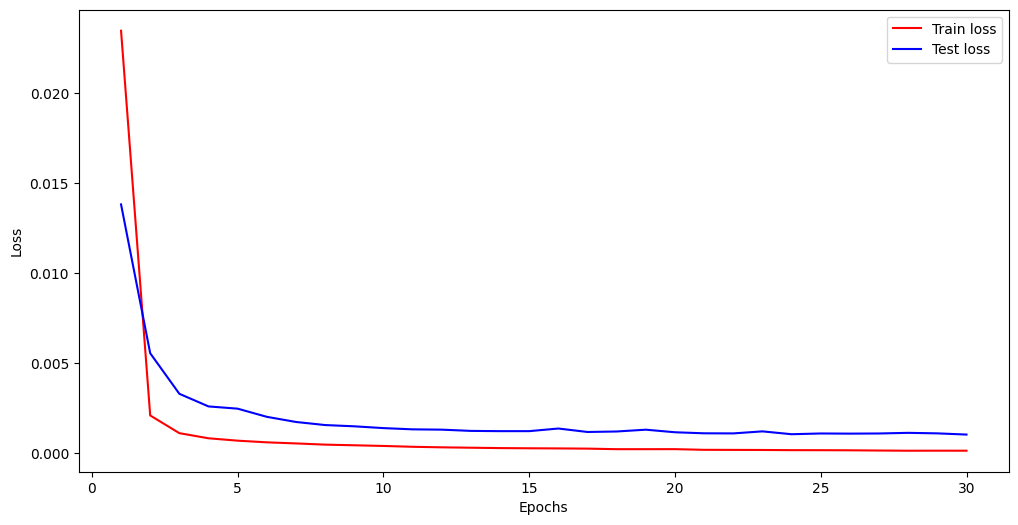

In [16]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(train_loss_np)+1), train_loss_np, label='Train loss', color='red')
plt.plot(range(1, len(test_loss_np)+1), test_loss_np, label='Test loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### Plotting the LR schedule plot

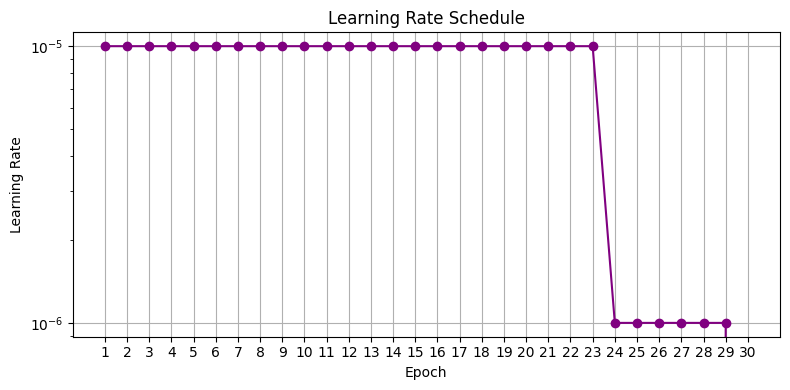

In [3]:
import matplotlib.pyplot as plt

# Learning rate for each of the 30 epochs
lrs = [
    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5,
    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5,
    1e-5, 1e-5, 1e-5, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 0.0
]
epochs = list(range(1, 31))

plt.figure(figsize=(8, 4))
plt.plot(epochs, lrs, marker='o', linestyle='-', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.xticks(epochs)
plt.yscale('log')  # because of the log-scale decay
plt.tight_layout()
plt.savefig('lr_schedule.png', dpi=600) 
plt.show()

### Train vs validation loss curve

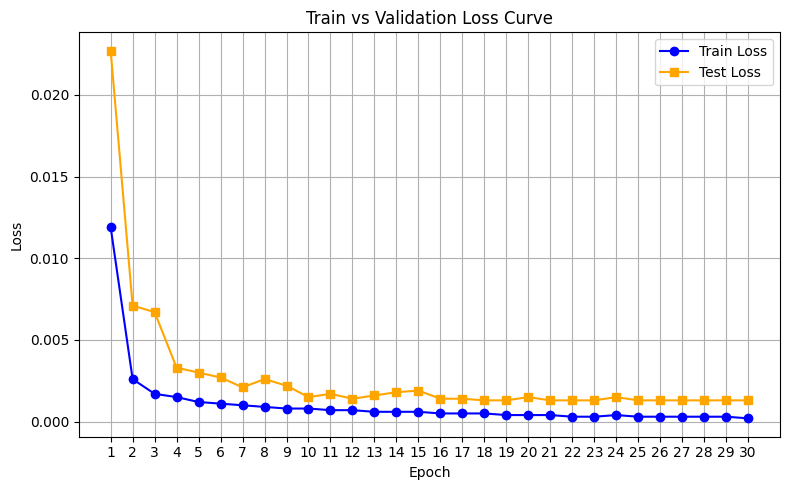

In [4]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 31))

# Train and test losses
train_loss = [
    0.0119, 0.0026, 0.0017, 0.0015, 0.0012, 0.0011, 0.0010, 0.0009, 0.0008, 0.0008,
    0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004,
    0.0004, 0.0003, 0.0003, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002
]

val_loss = [
    0.0227, 0.0071, 0.0067, 0.0033, 0.0030, 0.0027, 0.0021, 0.0026, 0.0022, 0.0015,
    0.0017, 0.0014, 0.0016, 0.0018, 0.0019, 0.0014, 0.0014, 0.0013, 0.0013, 0.0015,
    0.0013, 0.0013, 0.0013, 0.0015, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Test Loss', color='orange', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss Curve')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('train_test_loss.png', dpi=600)
plt.show()  # optional if you want to view it

# Saving model

In [17]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("carla_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "model_checkpoint_v7.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: carla_models\model_checkpoint_v7.pth
